# Gold EDA

This notebook conducts EDA aimed at generating a gold layer of data, which is considered ready for model consumption. EDA in this notebook will analyze the various predictor variables in the context of the "binds" target variable. It will also analyze some options for converting the "molecule_smiles" string representation of a molecule into a numeric representation that can be better consumed by a model. 

Recall this project uses a psuedo [medallion](https://www.databricks.com/glossary/medallion-architecture) where the gold layer is model ready data. 

In [1]:
import polars as pl
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors

import sys
sys.path.append('..')
from leash_bio_ai.utils.conf import silver_train_dir

In [2]:
silver_df = pl.read_parquet(source=silver_train_dir)
silver_df.head()

id,molecule_smiles,protein_int,binds
i64,str,i8,i8
466,"""C#CCOc1ccc(CNc2nc(NCc3ccc4[nH]…",1,1
467,"""C#CCOc1ccc(CNc2nc(NCc3ccc4[nH]…",2,1
683,"""C#CCOc1ccc(CNc2nc(NCC34CC5CC(C…",2,1
1321,"""C#CCOc1ccc(CNc2nc(Nc3n[nH]c4nc…",1,1
2141,"""C#CCOc1cccc(CNc2nc(NCc3ccc4[nH…",2,1


### Protein Integer

Recall the "protein_name" column was mapped into an integer column using {"BRD4":0, "HSA":1, "sEH":2}. Its useful to analyze if one of these proteins are more associated to positive "binds" target values to assess if the column would be useful in a model. An analysis of this is done below. 

In [3]:
pos_prtn_ct = (silver_df
               .filter(pl.col("binds") == 1)
               .group_by("protein_int")
               .count()
               .rename({"count":"pos_prtn_ct"}))

neg_prtn_ct = (silver_df
               .filter(pl.col("binds") == 0)
               .group_by("protein_int")
               .count()
               .rename({"count":"neg_prtn_ct"}))

tot_prtn_ct = (pos_prtn_ct
               .join(
                   other=neg_prtn_ct, 
                   how="inner", 
                   on="protein_int"))

tot_prtn_ct = (tot_prtn_ct
               .with_columns(
                   prtn_pct_pos=pl.col("pos_prtn_ct") / (pl.col("pos_prtn_ct") + pl.col("neg_prtn_ct")))
                .sort(by="protein_int", descending=False))

tot_prtn_ct.head()

C:\Users\btcai\AppData\Local\Temp\ipykernel_1572\3008273512.py:4: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  .count()
C:\Users\btcai\AppData\Local\Temp\ipykernel_1572\3008273512.py:10: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  .count()


protein_int,pos_prtn_ct,neg_prtn_ct,prtn_pct_pos
i8,u32,u32,f64
0,456964,983629,0.317205
1,408410,985841,0.292924
2,724532,981646,0.424652


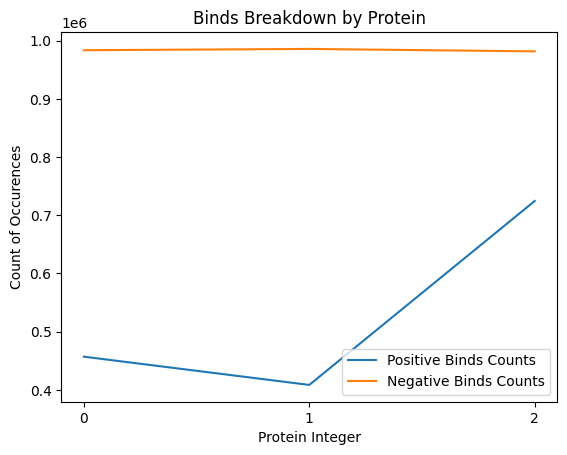

In [4]:
plt.plot(tot_prtn_ct["protein_int"], tot_prtn_ct["pos_prtn_ct"], label="Positive Binds Counts")
plt.plot(tot_prtn_ct["protein_int"], tot_prtn_ct["neg_prtn_ct"], label="Negative Binds Counts")
plt.xticks(ticks=[0,1,2])

plt.xlabel("Protein Integer")
plt.ylabel("Count of Occurences")
plt.title("Binds Breakdown by Protein")

plt.legend(loc="lower right")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


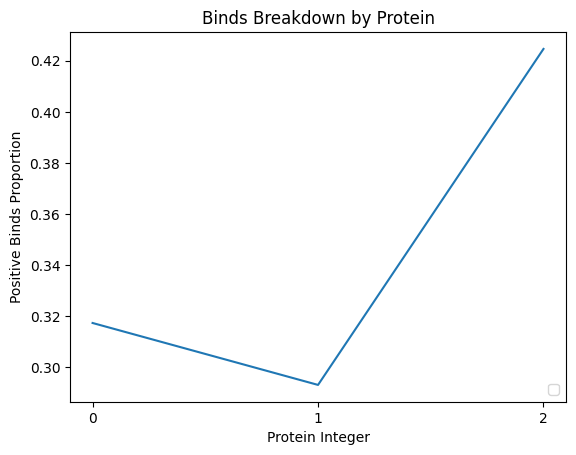

In [5]:
plt.plot(tot_prtn_ct["protein_int"], tot_prtn_ct["prtn_pct_pos"])
plt.xticks(ticks=[0,1,2])

plt.xlabel("Protein Integer")
plt.ylabel("Positive Binds Proportion")
plt.title("Binds Breakdown by Protein")

plt.legend(loc="lower right")

BRD4, HSA, and sEH all have similar value counts for negative "binds" records in the silver layer. This would indicate that they're likely relatively evenly associated with negative "binds" results due to the downsampling technique being random. sEH has the highest proportion of its appearances being with a positive "binds" value at 0.42 in the silver layer downsampled data. This indicates the sEH protein has a relationship with "binds" that causes higher positive instances. BRD4 and HSA have lower and similar positive "binds" incidence rates in the silver layer. 

Keep in mind there are almost certainly interactions amongst the "protein_int" and "molecule_smiles" feature columns so while this analysis is useful to motivate keeping "protein_int" as a feature due to sEH's higher incidence of positive "binds" there is likely a much more complex relationship going on here that ML models can pick up on. 

### Molecule Smiles

Here we utilize [RDKit Fingerprinting](https://www.rdkit.org/docs/GettingStartedInPython.html#fingerprinting-and-molecular-similarity) to specifically decompose the "molecule_smiles" column into a Morgan Fingerprint. In brief, morgan fingerprints describe molecules by way of a bit vector. The morgan fingerprint takes in 3 parameters:
- <b>molecule_smiles</b>: text representation of the molecule
- <b>length</b>: length of the bit vector
- <b>radius</b>: size of the atom groups (larger this is the more atom groups that can be represented by the bit vector)

Translating molecule_smiles into a morgan fingerprint allows us to make numerical predictors for a model to use via the bit vector that is generated. Keep in mind we don't want a model to memorize molecules that are specifically associated with positive "binds", rather we want to the model to learn molecule characteristics associated with positive "binds" so that the model generalizes well to new molecule types it has not seen before. 

In [6]:
def gen_bit_vec(fpgen, molecule_smile):
    mol = Chem.MolFromSmiles(molecule_smile)
    fpbit = fpgen.GetFingerprint(mol)
    return list(fpbit)

In [7]:
samp_df = silver_df.sample(n=50000, with_replacement=False, seed=5)
smiles = samp_df["molecule_smiles"].to_numpy()

#### Bit-Vector Features

In [8]:
lengths = [100, 500, 1024, 2048]

for length in lengths:
    fpgen = AllChem.GetMorganGenerator(radius=3, fpSize=length)
    bits = [gen_bit_vec(fpgen, x) for x in smiles]

    bits_df = pl.DataFrame(
        data=[pl.Series(f"bits_{length}", bits)], 
        schema={f"bits_{length}": pl.Array(pl.Int8, length)})
    samp_df = pl.concat(items=[samp_df, bits_df], how="horizontal")

In [9]:
for length in lengths:
    samp_df = samp_df.with_columns((pl.col(f"bits_{length}").arr.sum()).alias(f"sum_{length}"))
    samp_df = samp_df.with_columns((pl.col(f"bits_{length}").arr.std()).alias(f"std_{length}"))
    samp_df = samp_df.with_columns((pl.col(f"bits_{length}").arr.var()).alias(f"var_{length}"))

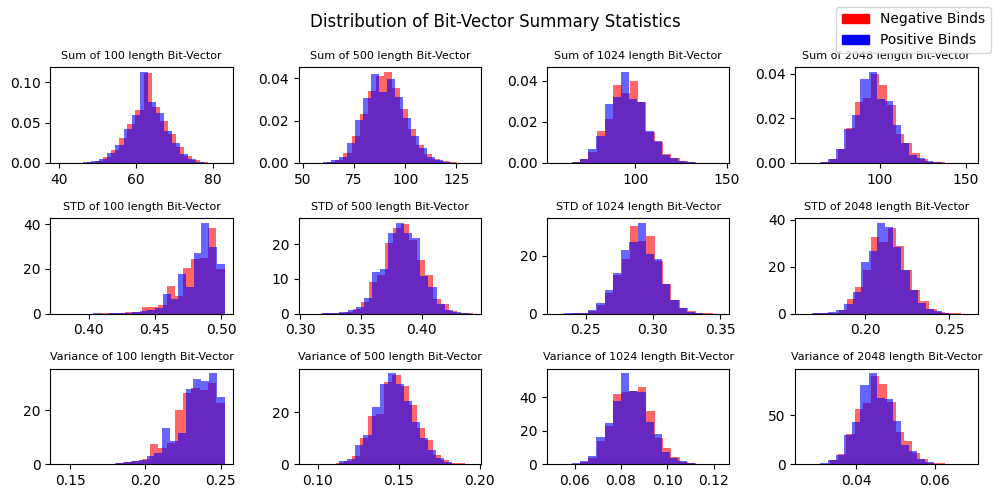

In [10]:
fig, ax = plt.subplots(3, 4, figsize=(10, 5))

col = 0
for length in lengths:

    ax[0, col].hist(samp_df.filter(pl.col("binds")==0).select(pl.col(f"sum_{length}")), bins=20, alpha=.6, density=True, color="red")
    ax[0, col].hist(samp_df.filter(pl.col("binds")==1).select(pl.col(f"sum_{length}")), bins=20, alpha=.6, density=True, color="blue")
    ax[0, col].set_title(f"Sum of {length} length Bit-Vector", size=8)

    ax[1, col].hist(samp_df.filter(pl.col("binds")==0).select(pl.col(f"std_{length}")), bins=20, alpha=.6, density=True, color="red")
    ax[1, col].hist(samp_df.filter(pl.col("binds")==1).select(pl.col(f"std_{length}")), bins=20, alpha=.6, density=True, color="blue")
    ax[1, col].set_title(f"STD of {length} length Bit-Vector", size=8)

    ax[2, col].hist(samp_df.filter(pl.col("binds")==0).select(pl.col(f"var_{length}")), bins=20, alpha=.6, density=True, color="red")
    ax[2, col].hist(samp_df.filter(pl.col("binds")==1).select(pl.col(f"var_{length}")), bins=20, alpha=.6, density=True, color="blue")
    ax[2, col].set_title(f"Variance of {length} length Bit-Vector", size=8)

    col += 1

blue_patch = mpatches.Patch(color='blue', label='Positive Binds')
red_patch = mpatches.Patch(color='red', label='Negative Binds')
fig.legend(handles=[red_patch, blue_patch])

fig.suptitle("Distribution of Bit-Vector Summary Statistics")
fig.tight_layout()

The summary statistics of the molecule Bit-Vectors do not seem to significantly differentiate between negative and positive "binds" occurences. The distributions of those statistics in the dataset are roughly the same for each "binds" class. Using these in an ML model to predict binds would likely only add noise to the training data and these shouldn't be included. 

#### Molecule Descriptors Features

In [11]:
def mol_desc(molecule_smile):
    mol = Chem.MolFromSmiles(molecule_smile)
    return [Descriptors.ExactMolWt(mol), 
            Descriptors.FpDensityMorgan1(mol), 
            Descriptors.FpDensityMorgan2(mol), 
            Descriptors.FpDensityMorgan3(mol), 
            Descriptors.HeavyAtomMolWt(mol),
            Descriptors.MolWt(mol), 
            Descriptors.NumRadicalElectrons(mol), 
            Descriptors.NumValenceElectrons(mol)]

In [12]:
%%capture

descs_data = [mol_desc(x) for x in smiles]

descs_cols = ["ExactMolWt", 
             "FpDensityMorgan1", 
             "FpDensityMorgan2", 
             "FpDensityMorgan3", 
             "HeavyAtomMolWt", 
             "MolWt", 
             "NumRadicalElectrons", 
             "NumValenceElectrons"]
descs_df = pl.DataFrame(data=descs_data, schema=descs_cols)
samp_df = pl.concat(items=[samp_df, descs_df], how="horizontal")

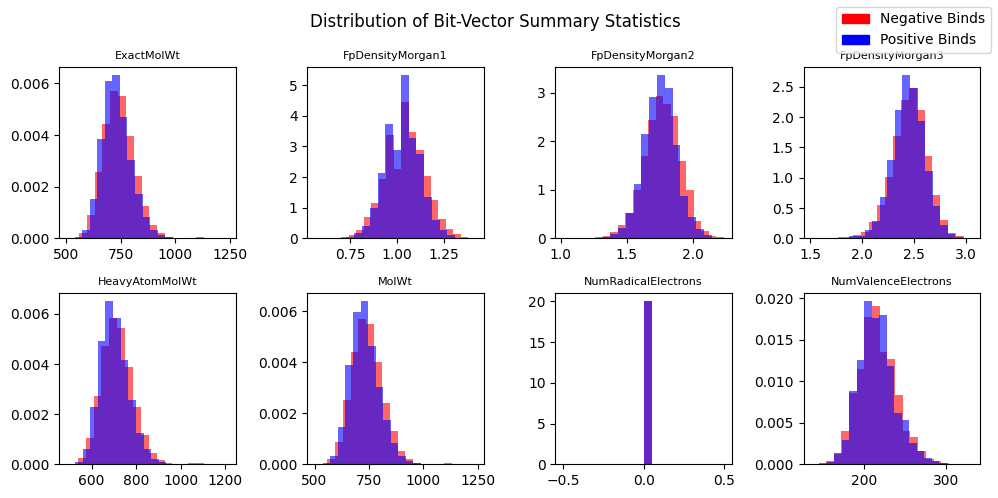

In [13]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))

row, col = 0, 0
for descs in descs_cols:

    ax[row, col].hist(samp_df.filter(pl.col("binds")==0).select(pl.col(descs)), bins=20, alpha=.6, density=True, color="red")
    ax[row, col].hist(samp_df.filter(pl.col("binds")==1).select(pl.col(descs)), bins=20, alpha=.6, density=True, color="blue")
    ax[row, col].set_title(descs, size=8)

    if col == 3:
        col = 0
        row += 1
    else:
        col += 1

blue_patch = mpatches.Patch(color='blue', label='Positive Binds')
red_patch = mpatches.Patch(color='red', label='Negative Binds')
fig.legend(handles=[red_patch, blue_patch])

fig.suptitle("Distribution of Bit-Vector Summary Statistics")
fig.tight_layout()

### Random Forest Feature Selection

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report

In [15]:
def rf_feat_imp(x_train, x_test, y_train, y_test, train_cols):

    rf = RandomForestClassifier(random_state=0)
    rf.fit(x_train, y_train)

    imps = list(zip(train_cols, rf.feature_importances_))
    imps.sort(key = lambda x : x[1])

    preds = rf.predict(x_test)
    acc = balanced_accuracy_score(y_test, preds)
    cr = classification_report(y_test, preds)

    return dict(imps), acc, cr

#### Bit-Vectors 100

In [44]:
bit_cols = []
for i in range(100):
    bit_cols.append(f"pos_{i}")

bit_df = pl.DataFrame(data=samp_df.select("bits_100").to_numpy(), schema=bit_cols)
bit_df = pl.concat(items=[bit_df, samp_df.select("binds")], how="horizontal")

In [45]:
imps, acc, cr = rf_feat_imp(x_train=bit_df.select(bit_cols)[0:40000], 
                            x_test=bit_df.select(bit_cols)[40000:], 
                            y_train=bit_df.select("binds")[0:40000], 
                            y_test=bit_df.select("binds")[40000:], 
                            train_cols=bit_cols)

c:\Users\btcai\OneDrive\documents\github\leash-bio-ai\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [46]:
print("Classification Report")
print(cr)

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      6624
           1       0.92      0.51      0.65      3376

    accuracy                           0.82     10000
   macro avg       0.86      0.74      0.77     10000
weighted avg       0.84      0.82      0.80     10000



Text(0, 0.5, 'Feature')

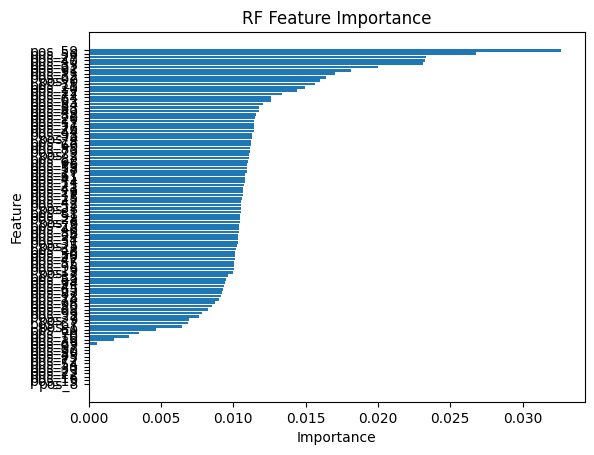

In [47]:
plt.barh(list(imps.keys()), imps.values())

plt.title("RF Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")

#### Bit Vectors 500

In [49]:
bit_cols = []
for i in range(500):
    bit_cols.append(f"pos_{i}")

bit_df = pl.DataFrame(data=samp_df.select("bits_500").to_numpy(), schema=bit_cols)
bit_df = pl.concat(items=[bit_df, samp_df.select("binds")], how="horizontal")

In [50]:
imps, acc, cr = rf_feat_imp(x_train=bit_df.select(bit_cols)[0:40000], 
                            x_test=bit_df.select(bit_cols)[40000:], 
                            y_train=bit_df.select("binds")[0:40000], 
                            y_test=bit_df.select("binds")[40000:], 
                            train_cols=bit_cols)

c:\Users\btcai\OneDrive\documents\github\leash-bio-ai\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [51]:
print("Classification Report")
print(cr)

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      6624
           1       0.90      0.70      0.78      3376

    accuracy                           0.87     10000
   macro avg       0.88      0.83      0.85     10000
weighted avg       0.87      0.87      0.87     10000



Text(0, 0.5, 'Feature')

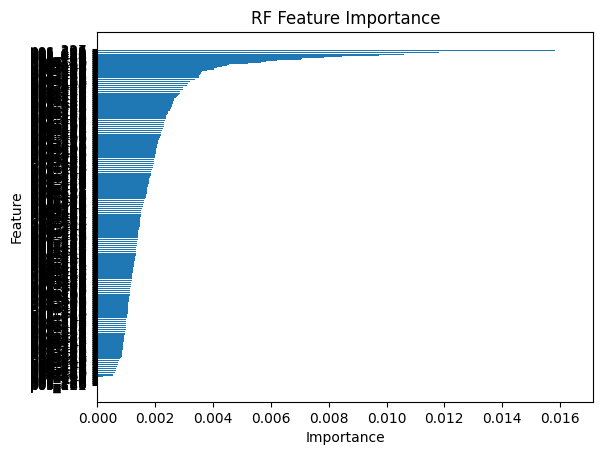

In [31]:
plt.barh(list(imps.keys()), imps.values())

plt.title("RF Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")

In [52]:
best_bits = {k:v for k,v in imps.items() if v >= .001}

In [55]:
list(best_bits.keys())

['pos_113',
 'pos_36',
 'pos_285',
 'pos_201',
 'pos_278',
 'pos_130',
 'pos_186',
 'pos_306',
 'pos_442',
 'pos_483',
 'pos_374',
 'pos_372',
 'pos_6',
 'pos_177',
 'pos_215',
 'pos_176',
 'pos_472',
 'pos_231',
 'pos_265',
 'pos_127',
 'pos_73',
 'pos_38',
 'pos_75',
 'pos_199',
 'pos_461',
 'pos_205',
 'pos_350',
 'pos_172',
 'pos_317',
 'pos_96',
 'pos_447',
 'pos_246',
 'pos_412',
 'pos_439',
 'pos_291',
 'pos_318',
 'pos_134',
 'pos_92',
 'pos_21',
 'pos_108',
 'pos_81',
 'pos_142',
 'pos_117',
 'pos_480',
 'pos_89',
 'pos_239',
 'pos_202',
 'pos_370',
 'pos_173',
 'pos_492',
 'pos_155',
 'pos_313',
 'pos_115',
 'pos_168',
 'pos_342',
 'pos_109',
 'pos_346',
 'pos_56',
 'pos_33',
 'pos_338',
 'pos_35',
 'pos_396',
 'pos_41',
 'pos_450',
 'pos_410',
 'pos_98',
 'pos_146',
 'pos_40',
 'pos_274',
 'pos_187',
 'pos_49',
 'pos_394',
 'pos_26',
 'pos_479',
 'pos_441',
 'pos_486',
 'pos_351',
 'pos_353',
 'pos_46',
 'pos_44',
 'pos_431',
 'pos_326',
 'pos_389',
 'pos_212',
 'pos_18',
 '

#### Bit-Vector Summary Statistics

In [20]:
stat_cols = []
for length in lengths:
    stat_cols.append(f"sum_{length}")
    stat_cols.append(f"std_{length}")
    stat_cols.append(f"var_{length}")

stats_df = samp_df.select(stat_cols + ["binds"])

In [21]:
imps, acc, cr = rf_feat_imp(x_train=stats_df.select(stat_cols)[0:40000], 
                            x_test=stats_df.select(stat_cols)[40000:], 
                            y_train=stats_df.select("binds")[0:40000], 
                            y_test=stats_df.select("binds")[40000:], 
                            train_cols=stat_cols)

c:\Users\btcai\OneDrive\documents\github\leash-bio-ai\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [22]:
print("Classification Report")
print(cr)

Classification Report
              precision    recall  f1-score   support

           0       0.66      0.73      0.69      6624
           1       0.34      0.27      0.30      3376

    accuracy                           0.57     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.55      0.57      0.56     10000



Text(0, 0.5, 'Feature')

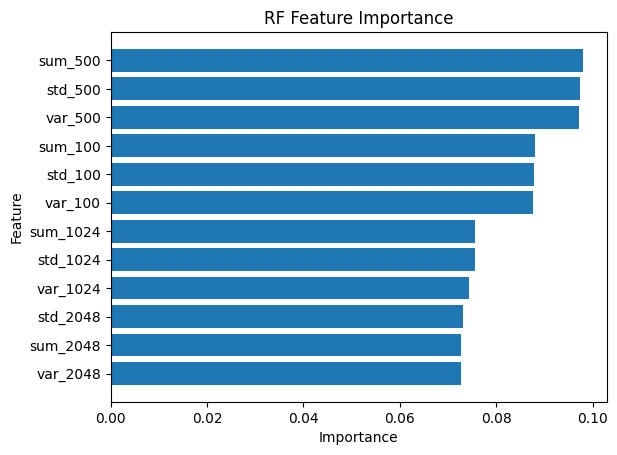

In [23]:
plt.barh(list(imps.keys()), imps.values())

plt.title("RF Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")

#### Molecule Descriptors

In [24]:
mol_descs_df = samp_df.select(descs_cols + ["binds"])

In [25]:
imps, acc, cr = rf_feat_imp(x_train=mol_descs_df.select(descs_cols)[0:40000], 
                            x_test=mol_descs_df.select(descs_cols)[40000:], 
                            y_train=mol_descs_df.select("binds")[0:40000], 
                            y_test=mol_descs_df.select("binds")[40000:],
                            train_cols=descs_cols)

c:\Users\btcai\OneDrive\documents\github\leash-bio-ai\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [26]:
print("Classification Report")
print(cr)

Classification Report
              precision    recall  f1-score   support

           0       0.70      0.85      0.76      6624
           1       0.48      0.28      0.35      3376

    accuracy                           0.65     10000
   macro avg       0.59      0.56      0.56     10000
weighted avg       0.62      0.65      0.63     10000



Text(0, 0.5, 'Feature')

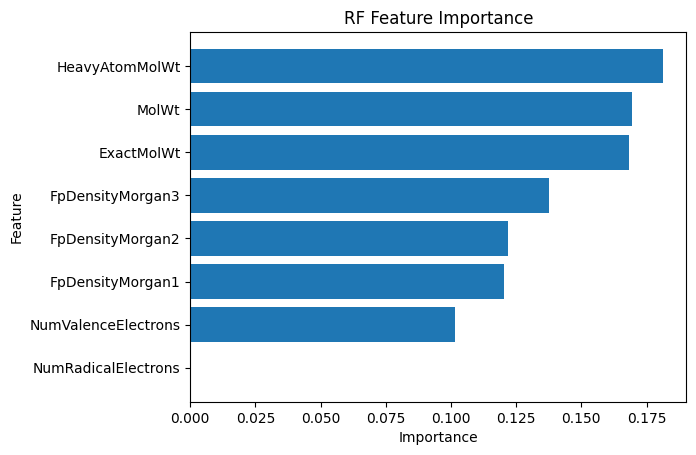

In [27]:
plt.barh(list(imps.keys()), imps.values())

plt.title("RF Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")

#### Combining Most Important Features

In [43]:
best_bits

{'pos_175': 0.017493801144233344,
 'pos_327': 0.018511059954563723,
 'pos_454': 0.020588607832313813,
 'pos_362': 0.0226862313485125,
 'pos_433': 0.02306697375066153,
 'pos_471': 0.028435781847048223,
 'pos_459': 0.03329513156102538,
 'pos_391': 0.04149539834052481,
 'pos_456': 0.04233457217522249,
 'sum_500': 0.04506995021972957,
 'var_500': 0.045320736932517224,
 'std_500': 0.04566507294953372,
 'NumValenceElectrons': 0.07283697887968438,
 'FpDensityMorgan2': 0.07944444615425192,
 'FpDensityMorgan1': 0.08251948136196957,
 'FpDensityMorgan3': 0.08764433669066436,
 'MolWt': 0.09613077283333568,
 'ExactMolWt': 0.09677678769276789,
 'HeavyAtomMolWt': 0.10068387833144009}

In [56]:
bit_cols = []
for i in range(500):
    bit_cols.append(f"pos_{i}")

bit_df = pl.DataFrame(data=samp_df.select("bits_500").to_numpy(), schema=bit_cols)
bit_best = list(best_bits.keys())
best_df = pl.concat(items=[bit_df.select(bit_best), samp_df.select("sum_500", "var_500", "std_500", "HeavyAtomMolWt", "MolWt", "ExactMolWt", "FpDensityMorgan3", "FpDensityMorgan2", "FpDensityMorgan1", "NumValenceElectrons", "binds")], how="horizontal")

In [57]:
best_cols = bit_best + ["sum_500", "var_500", "std_500", "HeavyAtomMolWt", "MolWt", "ExactMolWt", "FpDensityMorgan3", "FpDensityMorgan2", "FpDensityMorgan1", "NumValenceElectrons"]

In [58]:
imps, acc, cr = rf_feat_imp(x_train=best_df.select(best_cols)[0:40000], 
                            x_test=best_df.select(best_cols)[40000:], 
                            y_train=best_df.select("binds")[0:40000], 
                            y_test=best_df.select("binds")[40000:],
                            train_cols=best_cols)

c:\Users\btcai\OneDrive\documents\github\leash-bio-ai\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [59]:
print("Classification Report")
print(cr)

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      6624
           1       0.90      0.69      0.78      3376

    accuracy                           0.87     10000
   macro avg       0.88      0.82      0.84     10000
weighted avg       0.87      0.87      0.86     10000



Text(0, 0.5, 'Feature')

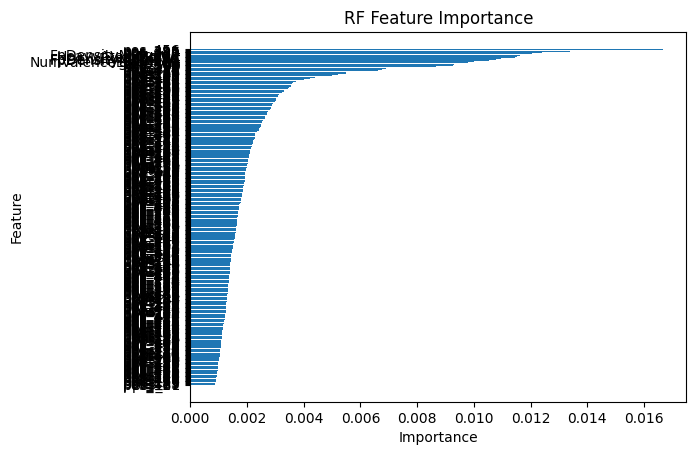

In [60]:
plt.barh(list(imps.keys()), imps.values())

plt.title("RF Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")

In [62]:
imps.keys()

dict_keys(['pos_81', 'pos_127', 'pos_483', 'pos_285', 'pos_75', 'pos_130', 'pos_186', 'pos_447', 'pos_73', 'pos_205', 'pos_318', 'pos_350', 'pos_246', 'pos_38', 'pos_201', 'pos_412', 'pos_199', 'pos_215', 'pos_410', 'pos_265', 'pos_372', 'pos_351', 'pos_291', 'pos_472', 'pos_231', 'pos_480', 'pos_113', 'pos_36', 'pos_239', 'pos_439', 'pos_172', 'pos_177', 'pos_96', 'pos_168', 'pos_306', 'pos_492', 'pos_98', 'pos_115', 'pos_176', 'pos_6', 'pos_278', 'pos_142', 'pos_155', 'pos_313', 'pos_21', 'pos_370', 'pos_374', 'pos_187', 'pos_338', 'pos_117', 'pos_396', 'pos_202', 'pos_109', 'pos_488', 'pos_289', 'pos_274', 'pos_89', 'pos_44', 'pos_134', 'pos_173', 'pos_92', 'pos_35', 'pos_108', 'pos_442', 'pos_353', 'pos_40', 'pos_342', 'pos_146', 'pos_346', 'pos_49', 'pos_270', 'pos_203', 'pos_461', 'pos_219', 'pos_450', 'pos_364', 'pos_389', 'pos_290', 'pos_431', 'pos_317', 'pos_441', 'pos_232', 'pos_326', 'pos_371', 'pos_479', 'pos_340', 'pos_394', 'pos_390', 'pos_257', 'pos_137', 'pos_37', 'pos_